In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor1m, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory

In [36]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/0106all.pkl'
arctic_df = pd.read_pickle(arctic_pkl)

In [37]:
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_df = pd.read_pickle(global_pkl)
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

## With SIC and MLD

In [3]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/0806all.pkl'
arctic_df = pd.read_pickle(arctic_pkl)

In [4]:
arctic_df

,depth,profile,latitude,longitude,cruise,S,T,log_eps,log_N2,dTdz,dSdz,hab,Tu,Tu_label,time,Rsubrho,sea_ice_concentration,MLDJ,MLDI
780,10.883087,1.0,80.698500,12.501000,HM,33.871593,1.536335,-8.630163,-3.959872,-0.497771,0.100644,-3349.116913,33.380924,Doubly stable,2015-08-14 08:28:04.999996796,-5.137611,0.27,1.0,161.0
781,10.883087,2.0,80.645000,12.502667,HM,34.570836,7.037067,-8.831877,-3.881950,-0.018245,0.023371,-3349.116913,-12.249080,Doubly stable,2015-08-14 11:13:10.999997780,-0.661290,0.27,3.0,36.0
782,10.883087,3.0,80.592000,12.489167,HM,34.773595,6.326570,-8.876662,-3.827860,-0.042101,0.015662,-3349.116913,-18.603494,Doubly stable,2015-08-14 13:25:23.000003768,-0.503521,0.38,0.0,7.0
783,10.883087,4.0,80.562833,12.512833,HM,34.580991,7.211281,-8.916865,-3.944777,-0.044053,0.024879,-3349.116913,-26.719226,Doubly stable,2015-08-14 16:00:43.999999388,-0.330649,0.27,0.0,434.0
784,10.883087,5.0,80.518500,12.495833,HM,34.529562,7.142208,-8.073179,-4.046251,-0.000670,0.033586,-3349.116913,-19.341435,Doubly stable,2015-08-14 17:54:57.000003980,-0.484064,0.38,2.0,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21427,61.000000,16.0,79.414267,125.987333,ASBO,34.050500,-1.709000,-6.327902,-4.323464,0.011000,0.009000,-3498.000000,-48.468114,Diffusive Convection,2007-09-18 15:28:59.999997000,0.060604,0.00,7.0,7.0
21428,61.000000,17.0,80.788717,138.627200,ASBO,33.899000,-1.660000,-6.602060,-4.147692,0.004000,0.009500,-3299.000000,-42.456320,Doubly stable,2007-09-19 13:19:59.999996000,-0.044425,0.00,8.0,24.0
21435,61.000000,24.0,79.630017,142.701733,ASBO,33.965000,-1.590000,-7.045757,-4.590205,0.015250,0.008500,-3464.000000,-47.205189,Diffusive Convection,2007-09-20 18:31:59.999996000,0.038507,0.00,0.0,50.0
21442,61.000000,31.0,79.468683,158.588767,ASBO,33.625000,-1.398000,-6.207608,-3.657629,0.004500,0.028750,-3474.000000,-45.360610,Diffusive Convection,2007-09-22 06:28:00.000000000,0.006294,0.00,0.0,9.0


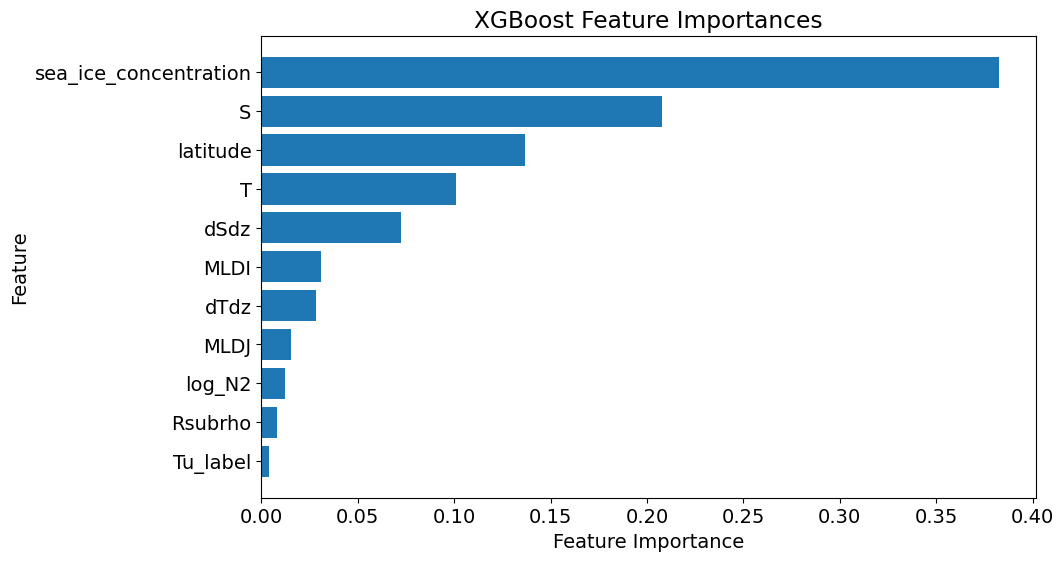

In [12]:
# Features:
# excluded 'depth','hab', 
xstringlist_all = ['S','T','latitude', 'dSdz','dTdz','log_N2', 'Tu_label', 'sea_ice_concentration', 'MLDJ', 'MLDI', 'Rsubrho']

# We want to predict:
ystringlist_all = ['log_eps']

xgb_regressor_all, r2_all, y_test_all, y_pred_all, X_test_all, feature_importances_all = XGBoost_regressor(arctic_df, xstringlist_all , ystringlist_all)

In [13]:
print(r2_all)

0.7623211927894912


In [17]:
# Reshape y_pred
y_pred_all = np.reshape(y_pred_all, (-1, 1))

X_test_df = pd.DataFrame(X_test_all, columns=xstringlist_all)
y_test_df = pd.DataFrame(y_test_all, columns=ystringlist_all)
y_pred_df = pd.DataFrame(y_pred_all, columns=['eps_pred'])

arctic_all_testdf = create_testdf(X_test_df, y_test_df, y_pred_df)
#plot_residuals(arctic_all_testdf)

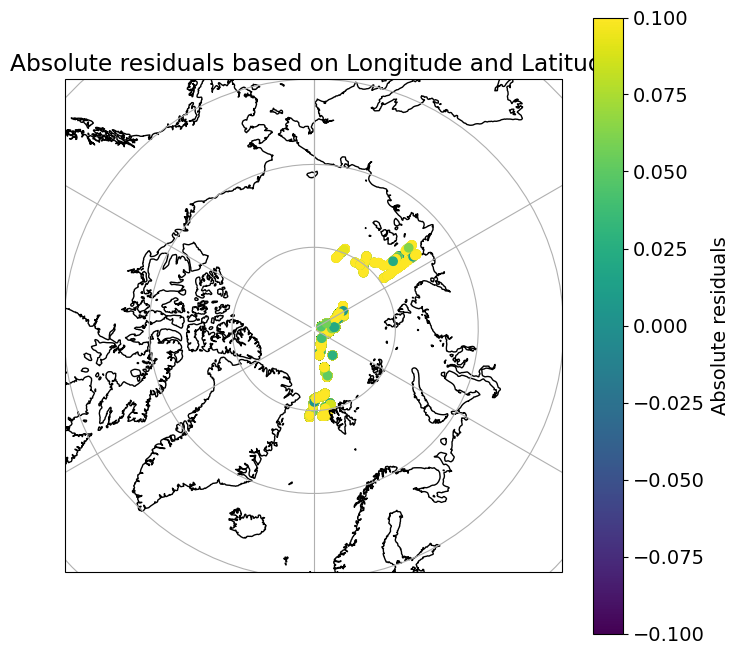

In [23]:
merged_df = arctic_all_testdf.merge(arctic_df, on=xstringlist_all+ystringlist_all)
merged_df = merged_df.drop_duplicates(subset=xstringlist_all+ystringlist_all)
residuals = (merged_df["log_eps"] - merged_df["eps_pred"])
stereo_plot(merged_df, residuals, "Absolute residuals")

## Regressor for upper 30 meters

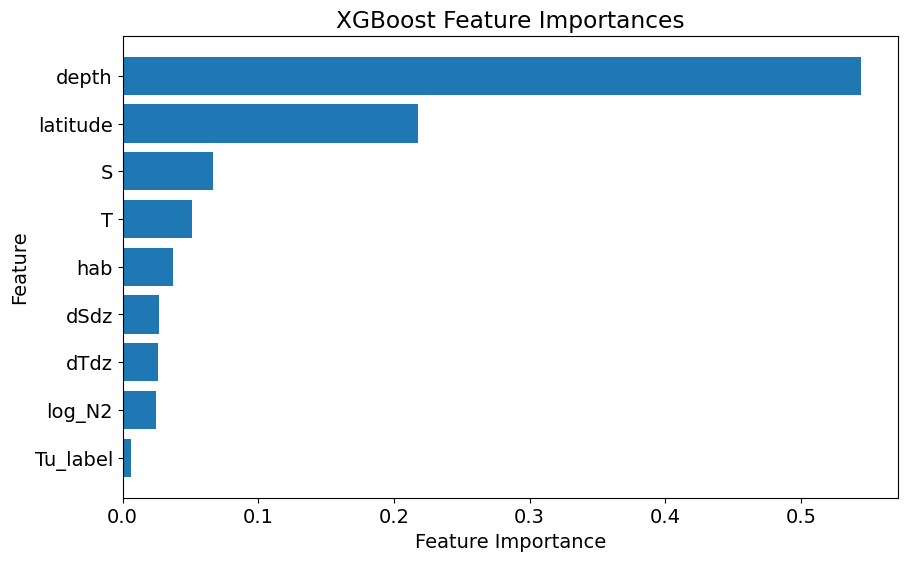

In [38]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']

xgb_regressor1, r21, y_test1, y_pred1, X_test1, feature_importances1 = XGBoost_regressor1m(arctic_df, xstringlist , ystringlist)

In [39]:
print(r21)

0.8066303485113369


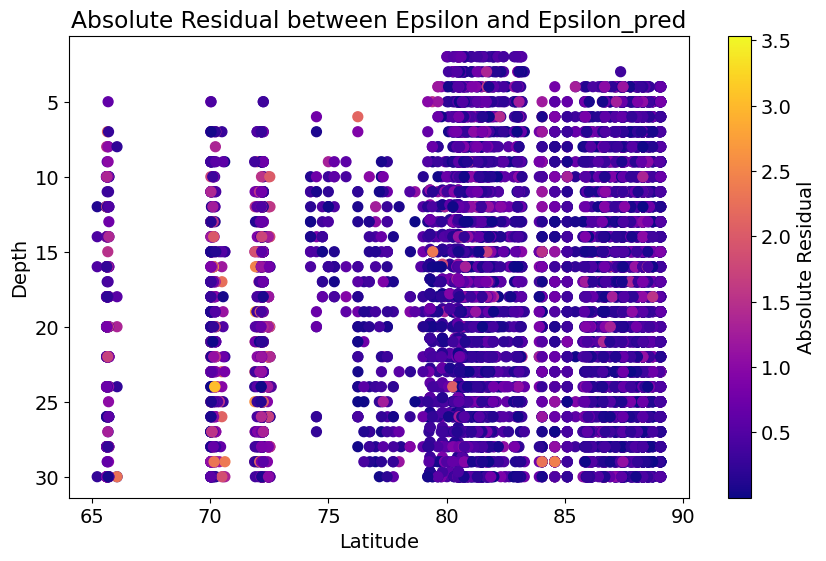

In [40]:
# Reshape y_pred
y_pred1 = np.reshape(y_pred1, (-1, 1))

X_test_df = pd.DataFrame(X_test1, columns=xstringlist)
y_test_df = pd.DataFrame(y_test1, columns=ystringlist)
y_pred_df = pd.DataFrame(y_pred1, columns=['eps_pred'])

arctic30m_testdf = create_testdf(X_test_df, y_test_df, y_pred_df)
plot_residuals(arctic30m_testdf)

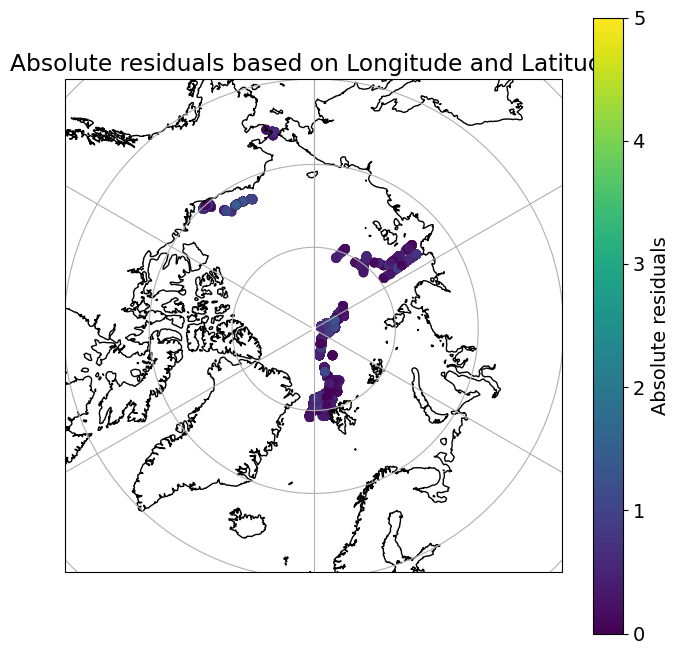

In [41]:
merged_df30m = arctic30m_testdf.merge(arctic_df, on=xstringlist+ystringlist)
merged_df30m = merged_df30m.drop_duplicates(subset=xstringlist+ystringlist)
residuals = merged_df30m["log_eps"] - merged_df30m["eps_pred"]
stereo_plot(merged_df30m, residuals, "Absolute residuals", 0, 5)

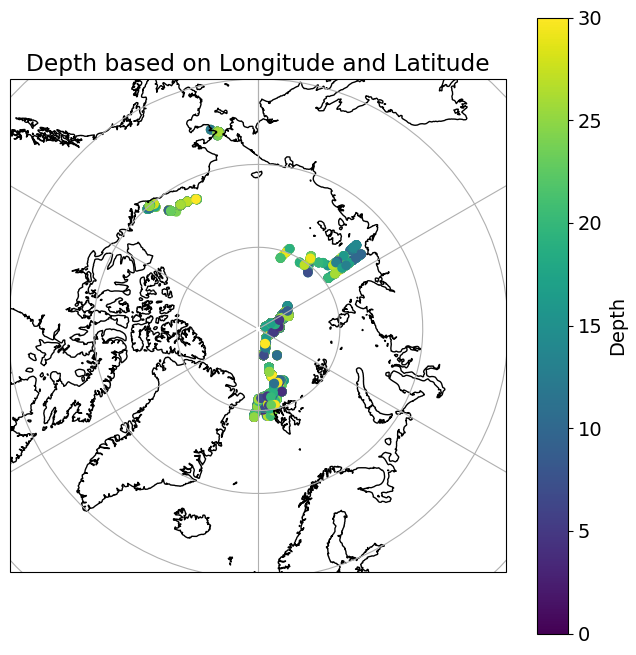

In [42]:
stereo_plot(merged_df30m, merged_df30m["depth"], "Depth", 0, 30)

In [9]:
calc_correlation(merged_df30m)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 4 has 1 dimension(s)

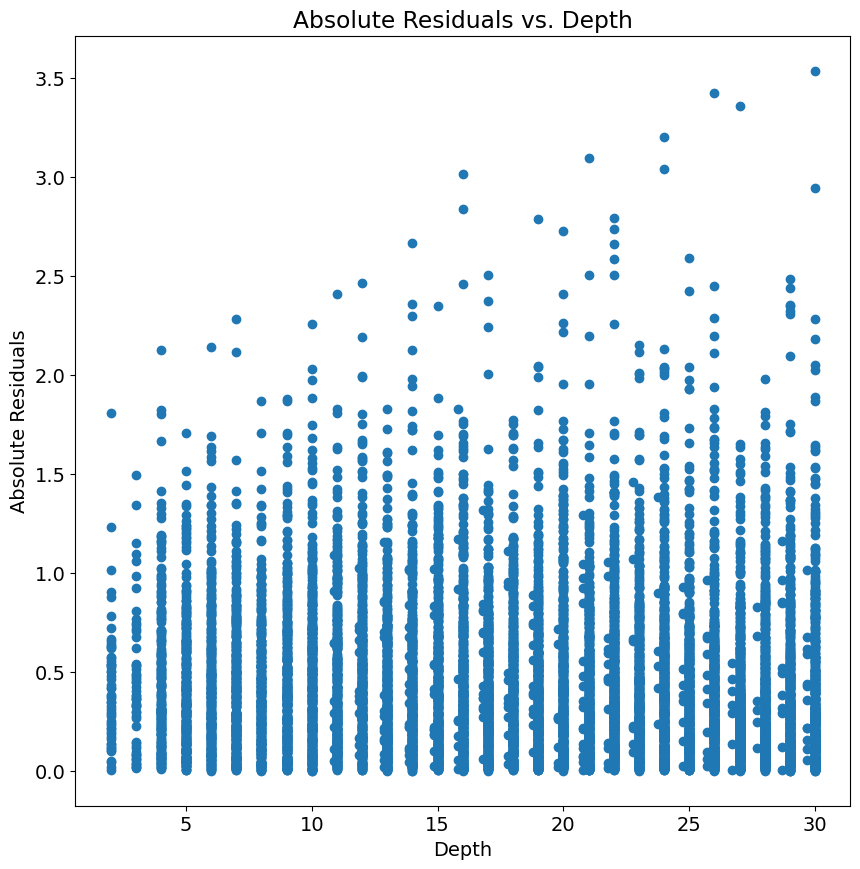

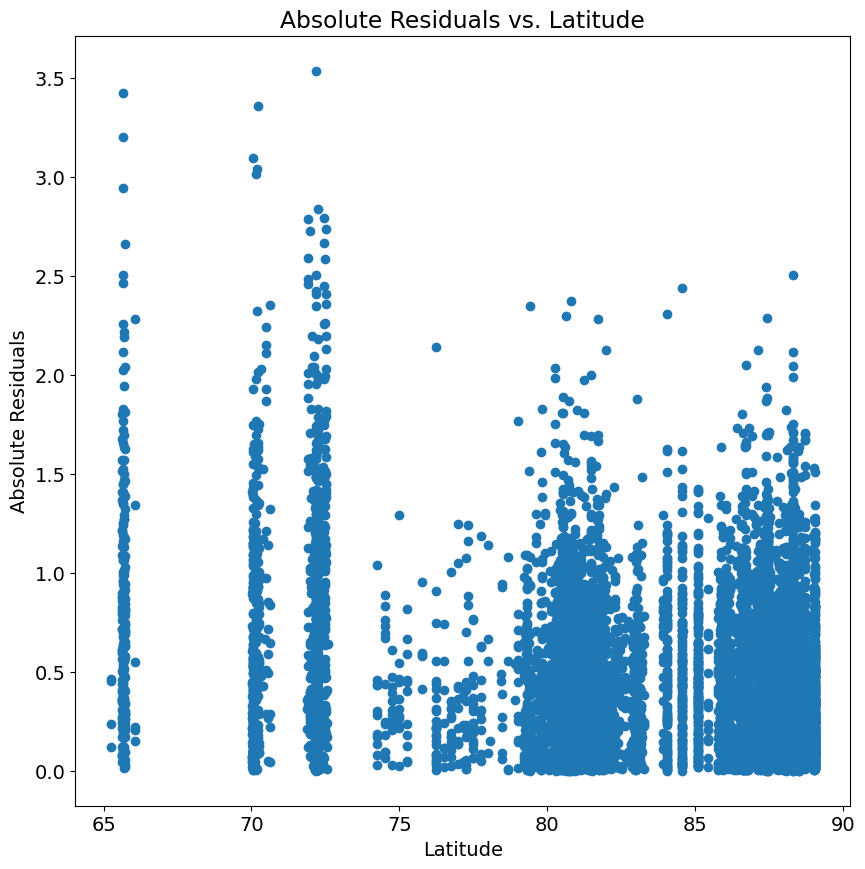

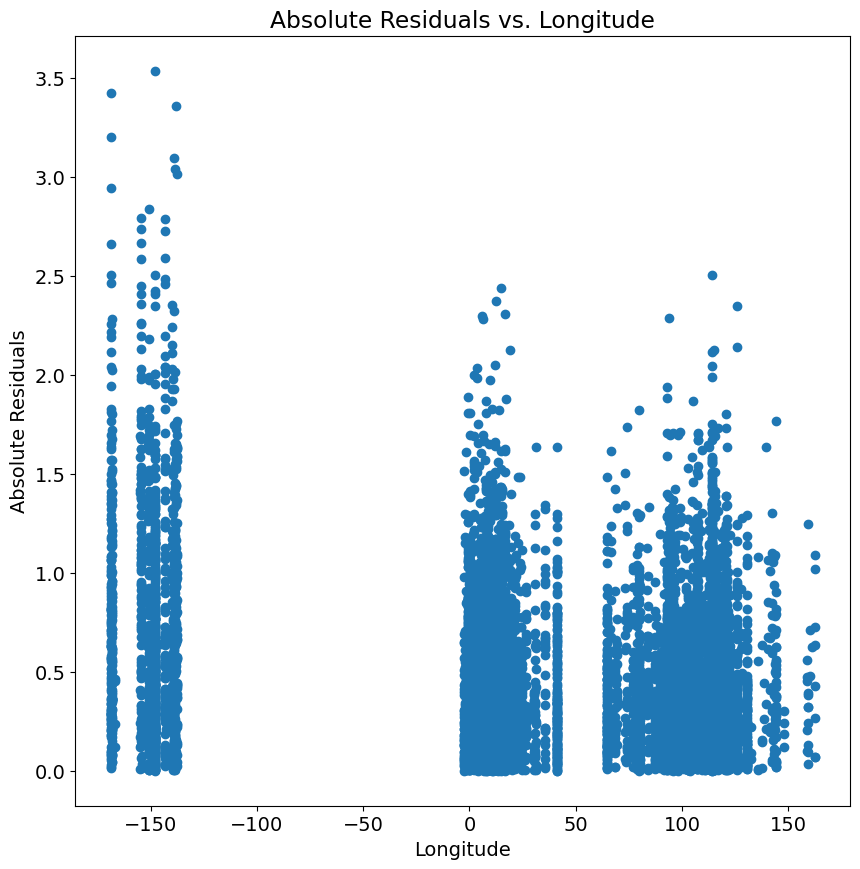

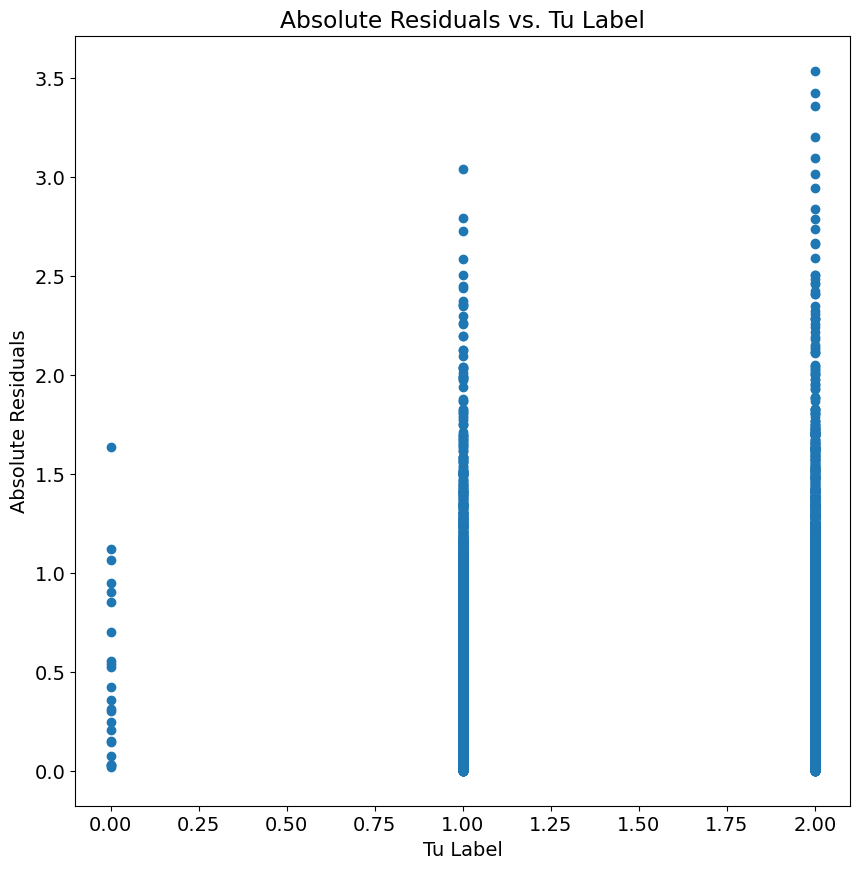

In [43]:
plot_correlations(merged_df30m)

## Test this on deep ocean data

In [29]:
X_test_new = arctic_df[(arctic_df['depth'] > 30) & (arctic_df['depth'] < 300)][xstringlist]
y_test_new = arctic_df[(arctic_df['depth'] > 30) & (arctic_df['depth'] < 300)][ystringlist]
y_pred_new = xgb_regressor1.predict(X_test_new)
r2 = r2_score(y_test_new, y_pred_new)
print(r2)

-2.954423338327577


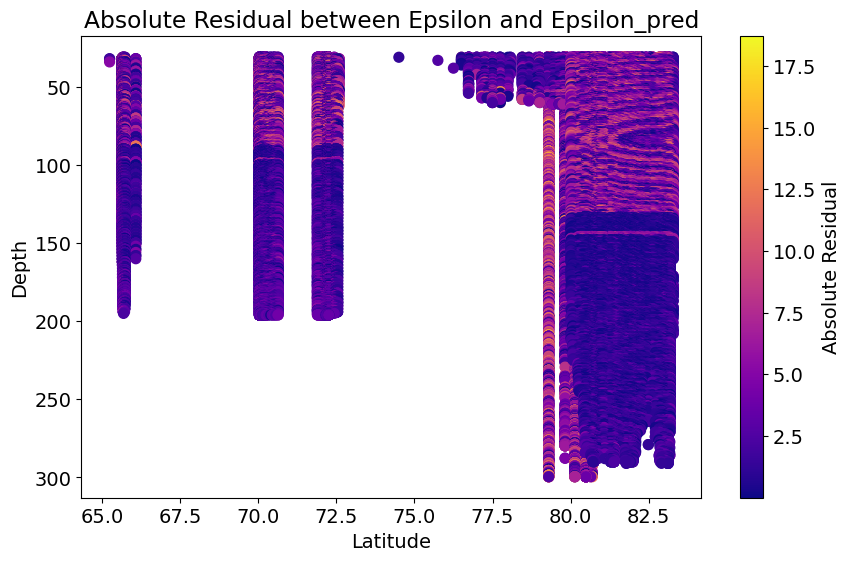

In [30]:
# Reshape y_pred
y_pred_new = np.reshape(y_pred_new, (-1, 1))
X_test_df2 = pd.DataFrame(X_test_new, columns=xstringlist)
y_test_df2 = pd.DataFrame(y_test_new, columns=ystringlist)
y_pred_df2 = pd.DataFrame(y_pred_new, columns=['eps_pred'])

arctic30m_testdf_new = create_testdf(X_test_df2, y_test_df2, y_pred_df2)
plot_residuals(arctic30m_testdf_new)

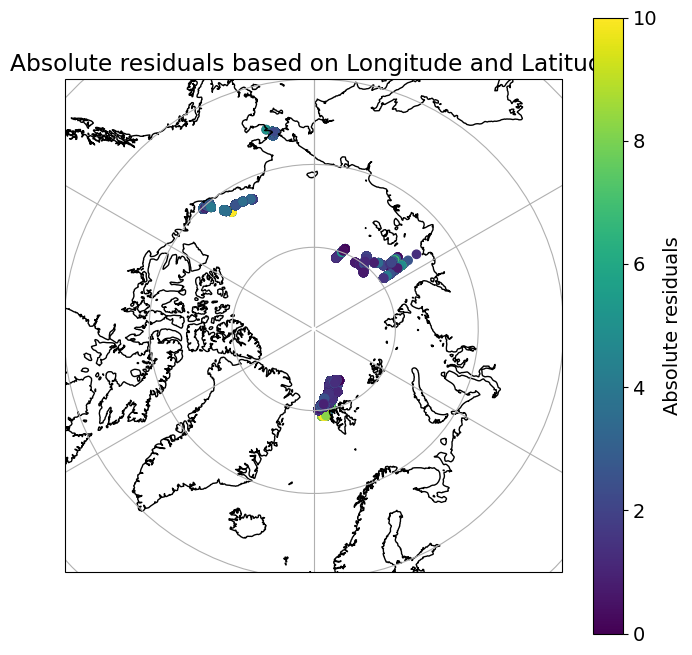

In [31]:
arctic30m_testdf_new["absolute_residuals"] = np.abs(arctic30m_testdf_new["log_eps"] - arctic30m_testdf_new["eps_pred"])
arctic30m_mergeddf_new= arctic30m_testdf_new.merge(arctic_df, on=xstringlist+ystringlist)
arctic30m_mergeddf_new = arctic30m_mergeddf_new.drop_duplicates(subset=xstringlist+ystringlist)

stereo_plot(arctic30m_mergeddf_new, arctic30m_mergeddf_new["absolute_residuals"], "Absolute residuals", 0, 10)

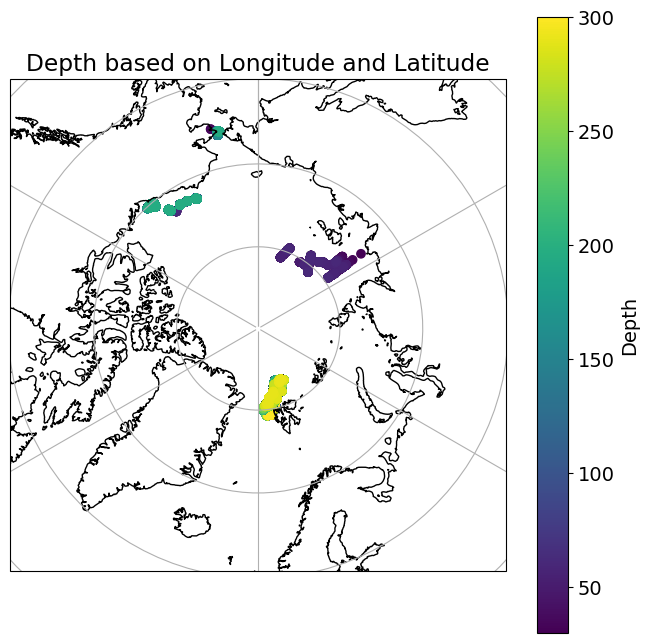

In [32]:
stereo_plot(arctic30m_mergeddf_new, arctic30m_mergeddf_new["depth"], "Depth", 30, 300)

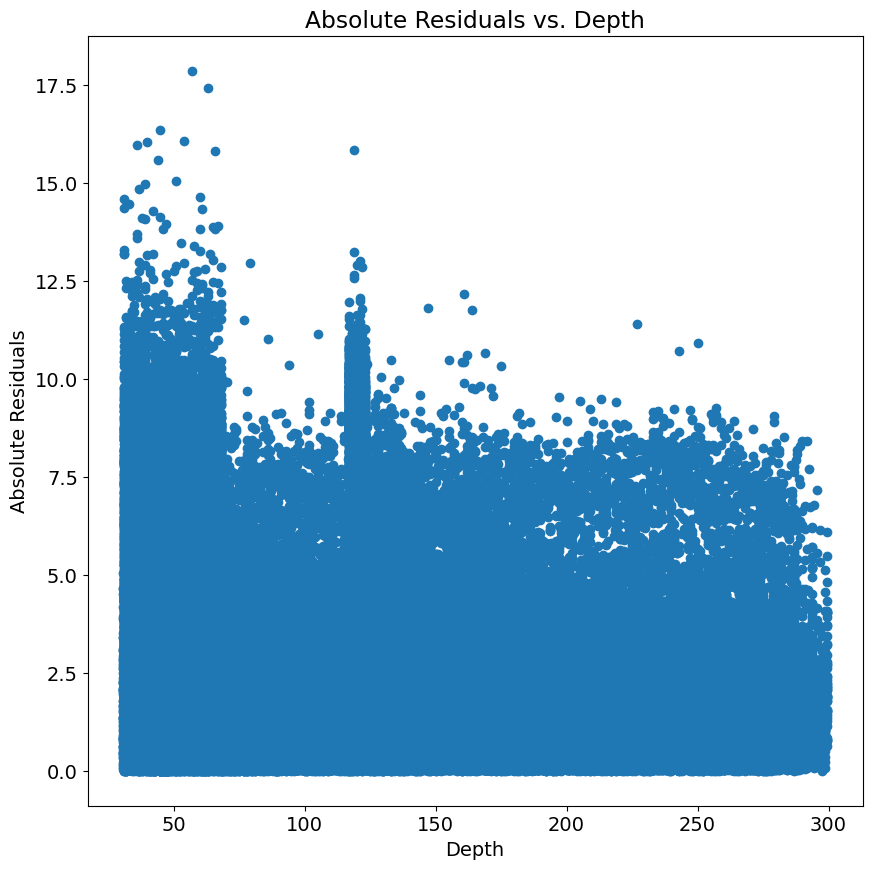

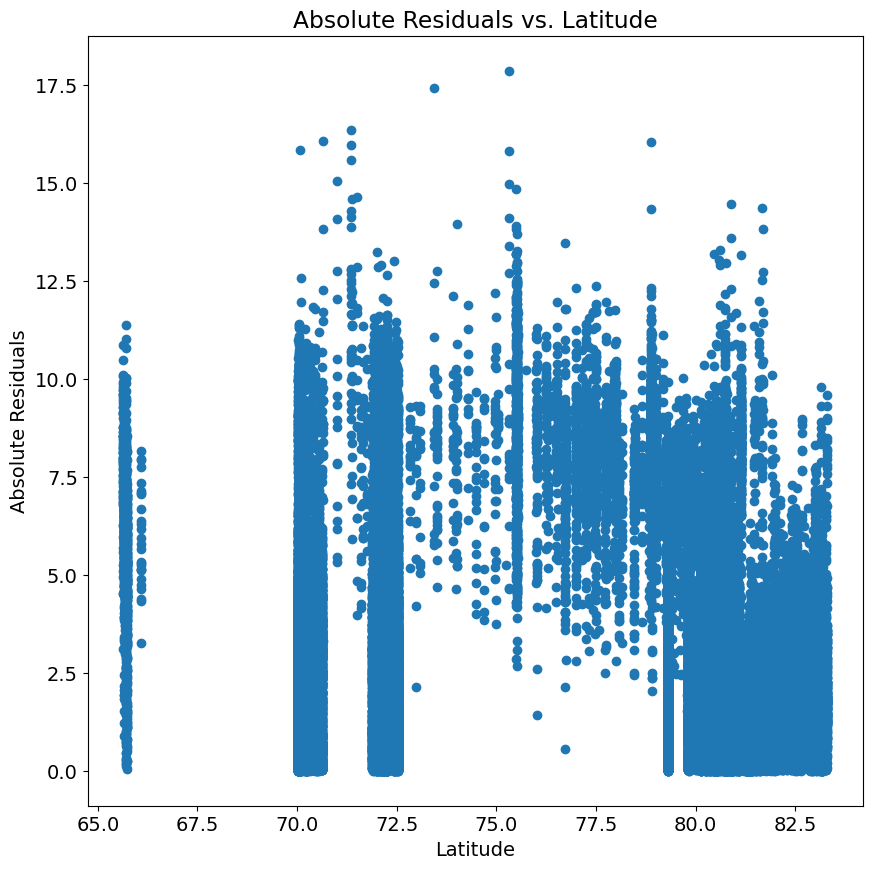

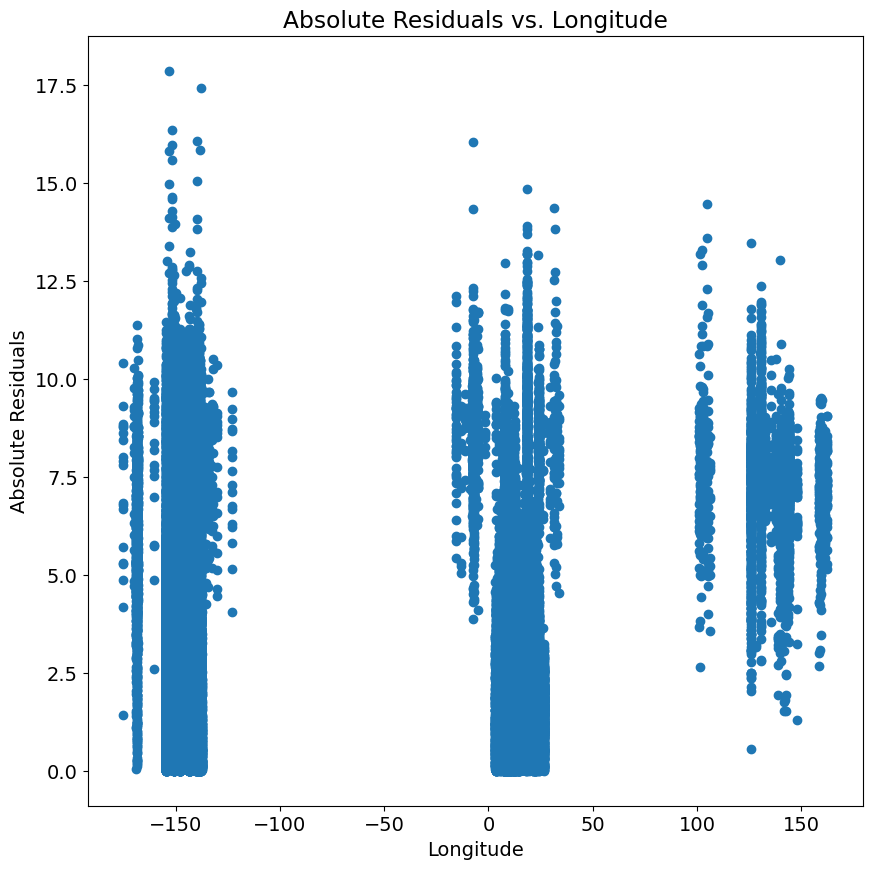

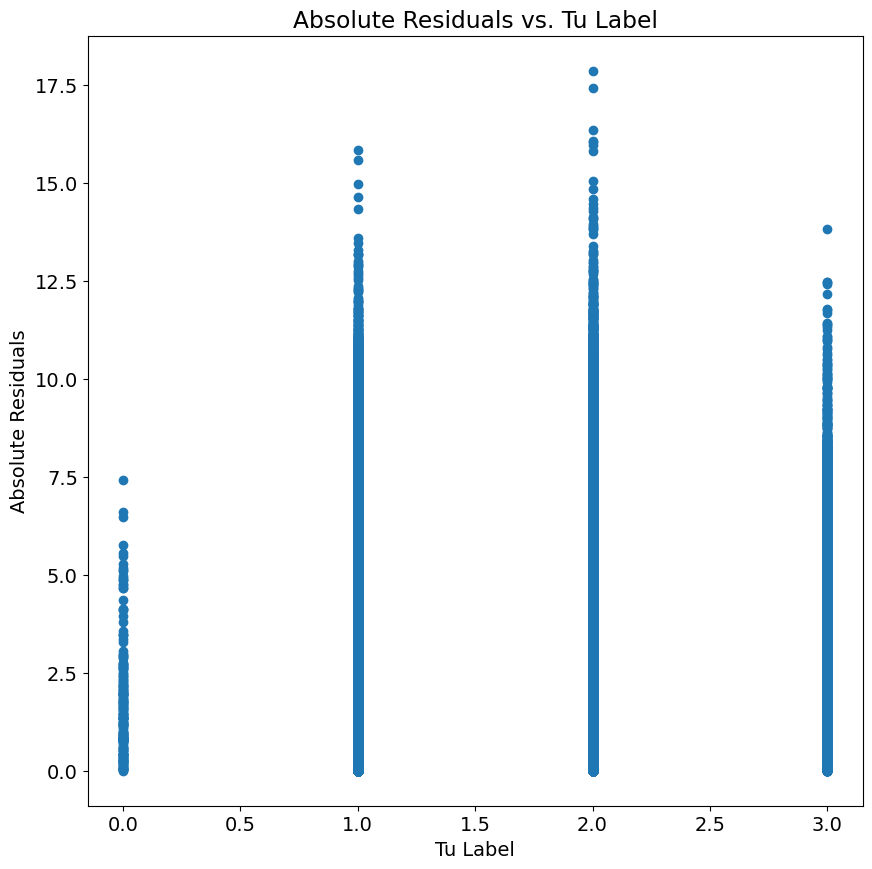

In [62]:
plot_correlations(arctic30m_mergeddf_new)

## Regressor for upper 300m

In [44]:

X = arctic_df[xstringlist]
y = arctic_df[ystringlist]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)


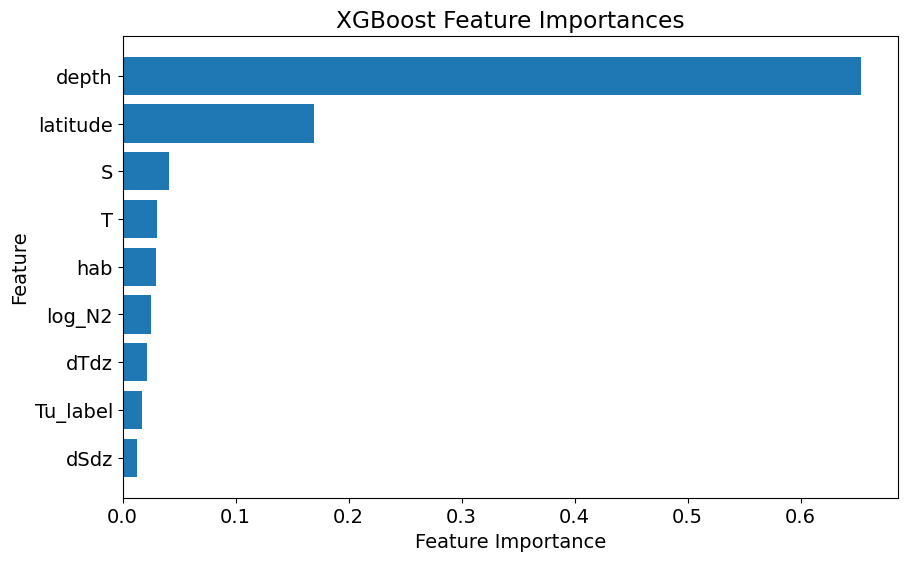

In [45]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']

xgb_regressor, r2, y_test, y_pred, X_test, feature_importances = XGBoost_regressor(arctic_df, xstringlist , ystringlist)

In [46]:
print(r2)

0.8005843169895295


## Evaluate performance

In [47]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']
# Reshape y_pred
y_pred = np.reshape(y_pred, (-1, 1))
X_test_df = pd.DataFrame(X_test, columns=xstringlist)
y_test_df = pd.DataFrame(y_test, columns=ystringlist)
y_pred_df = pd.DataFrame(y_pred, columns=['eps_pred'])

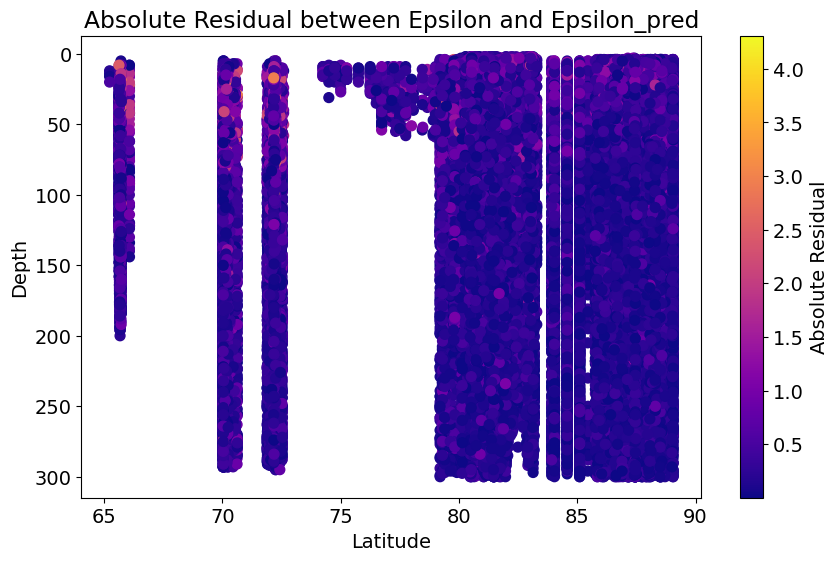

In [48]:
arctic_testdf = create_testdf(X_test_df, y_test_df, y_pred_df)
plot_residuals(arctic_testdf)

ValueError: 'c' argument has 11060 elements, which is inconsistent with 'x' and 'y' with size 108282.

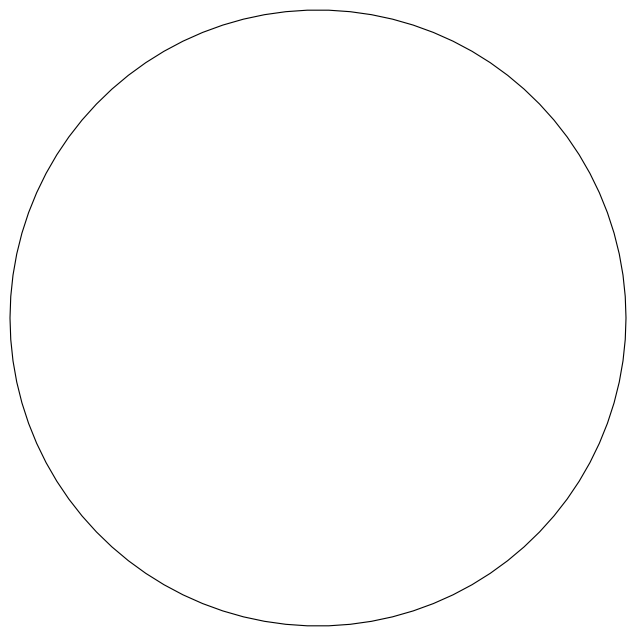

In [49]:
merged_df = arctic_testdf.merge(arctic_df, on=xstringlist+ystringlist)
merged_df = merged_df.drop_duplicates(subset=xstringlist+ystringlist)
residuals = y_test1 - y_pred1
stereo_plot(merged_df, residuals, "Absolute residuals", 0, 5)

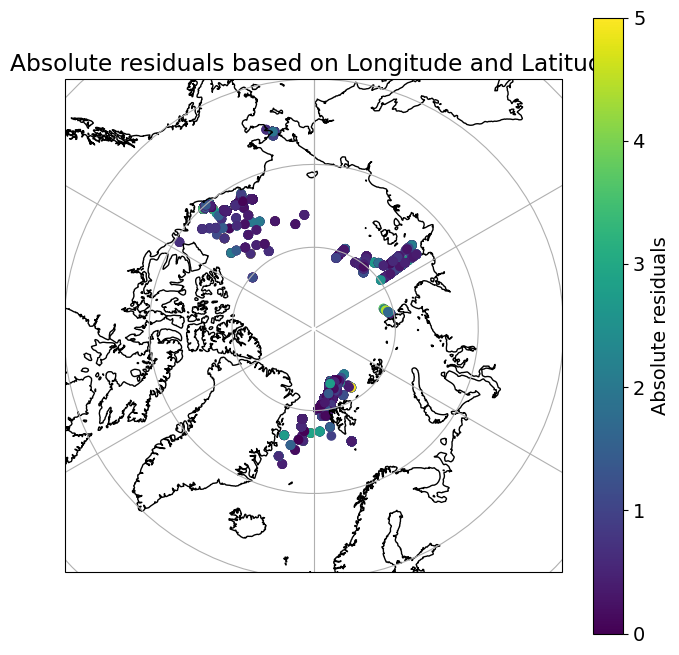

In [43]:
stereo_plot(merged_df)

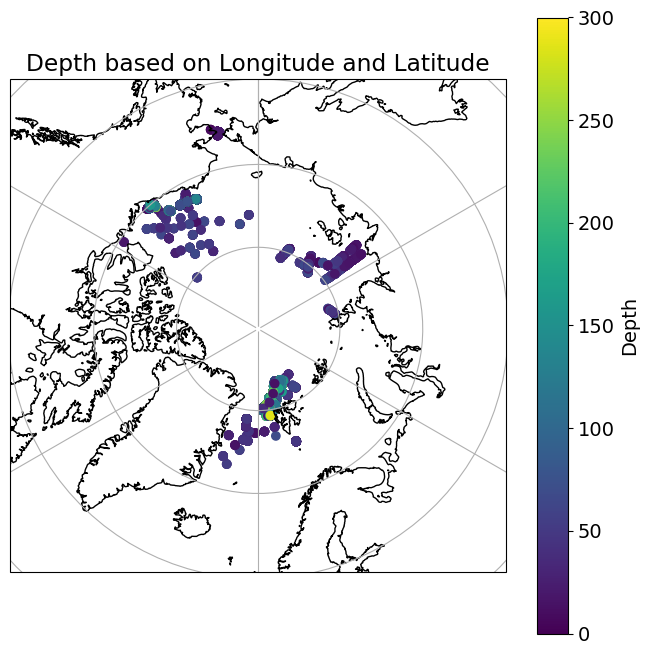

In [45]:
stereo_plot(merged_df, merged_df["depth"], "Depth", 0, 300)

In [50]:
calc_correlation(merged_df)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 4 has 1 dimension(s)

- depth: the absolute residuals tend to decrease. In other words, there is a weak negative linear relationship between depth and the absolute residuals.
- latitude: The correlation coefficient between latitude and absolute residuals is approximately -0.13. This negative correlation indicates that as latitude increases (moving towards higher latitudes), the absolute residuals tend to decrease. However, the correlation is relatively weak.
- Longitude: The correlation coefficient between longitude and absolute residuals is approximately -0.085. This negative correlation suggests that there is a very weak negative linear relationship between longitude and the absolute residuals. However, the correlation is quite weak, indicating that longitude may not have a strong influence on the absolute residuals.
- Tu Label: The correlation coefficient between tu_label and absolute residuals is approximately 0.031. This positive correlation indicates a weak positive linear relationship between tu_label and the absolute residuals. However, the correlation is quite weak, suggesting that tu_label may not have a strong influence on the absolute residuals.

In [51]:
merged_df["absolute_residuals"] = np.abs(merged_df["log_eps"] - merged_df["eps_pred"])

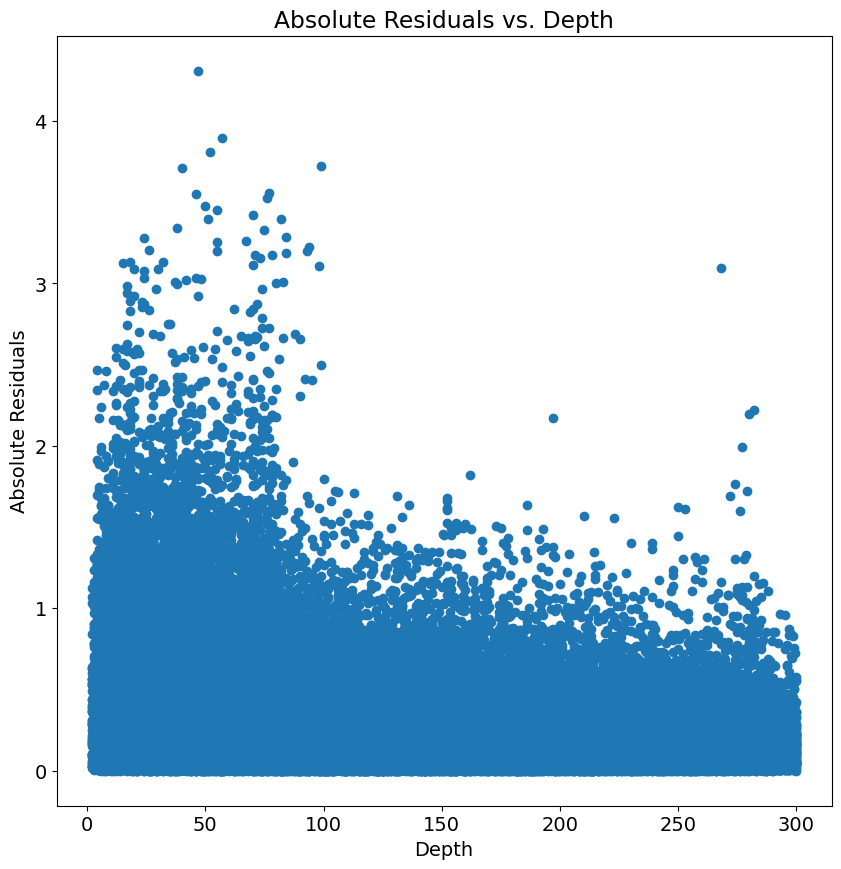

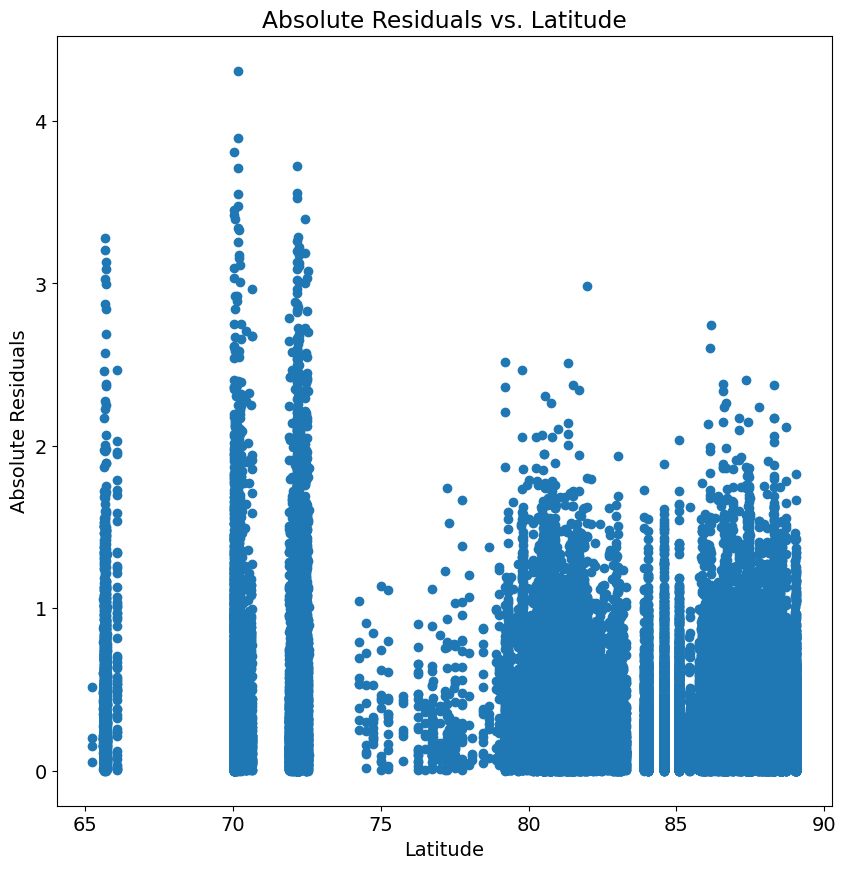

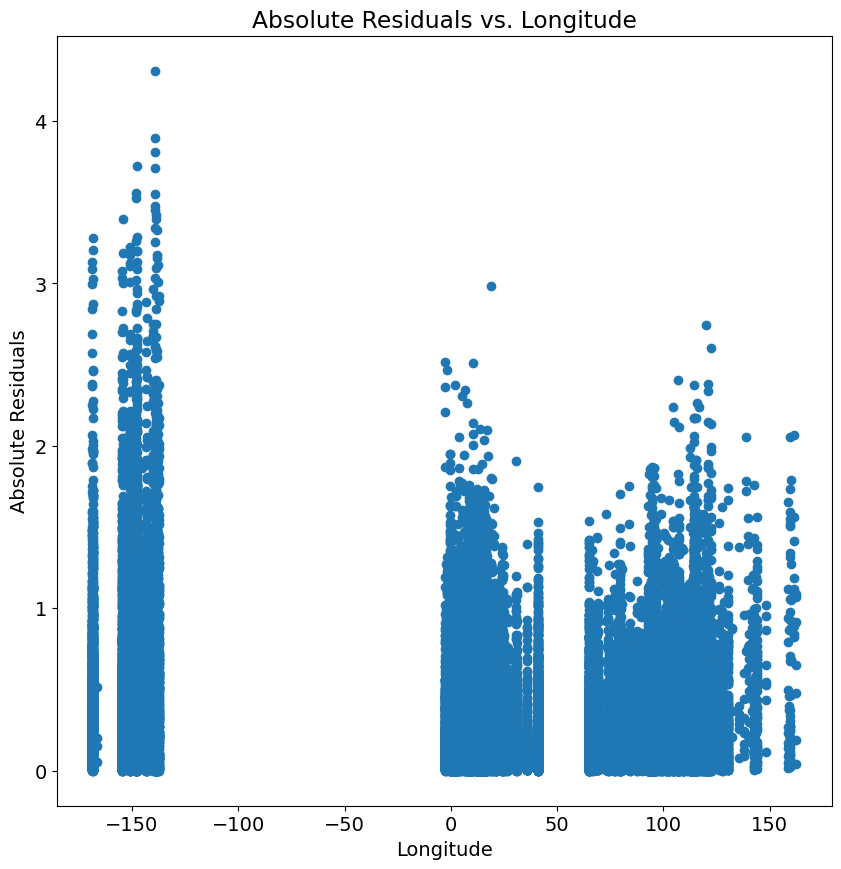

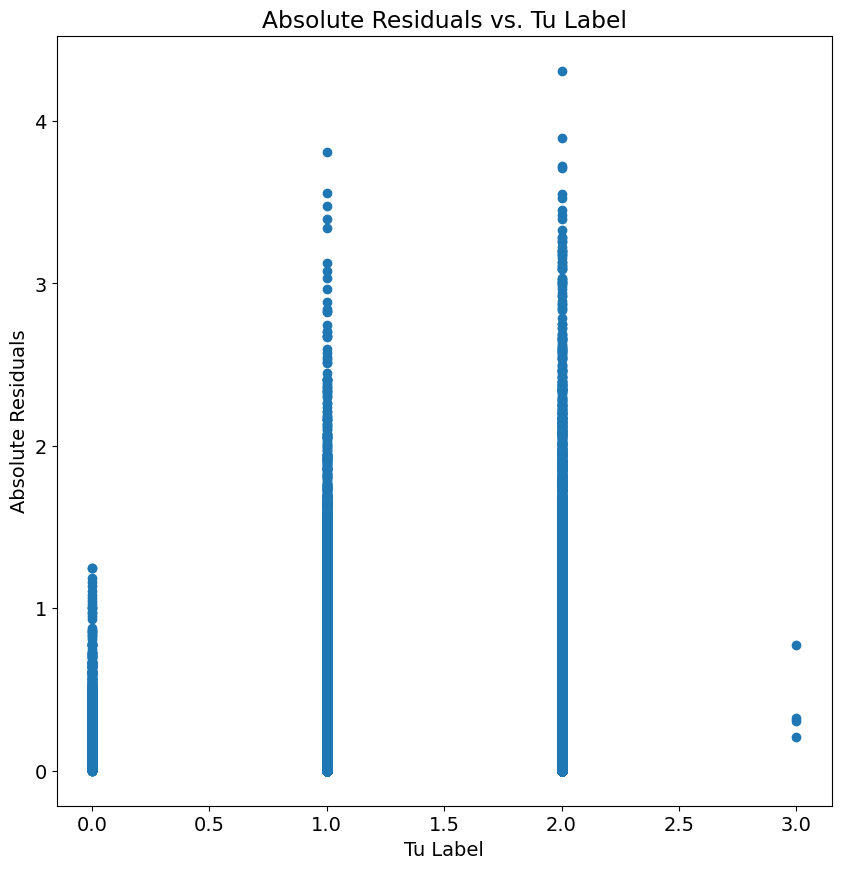

In [52]:
plot_correlations(merged_df)

# See if we can predict southern ocean with this model.

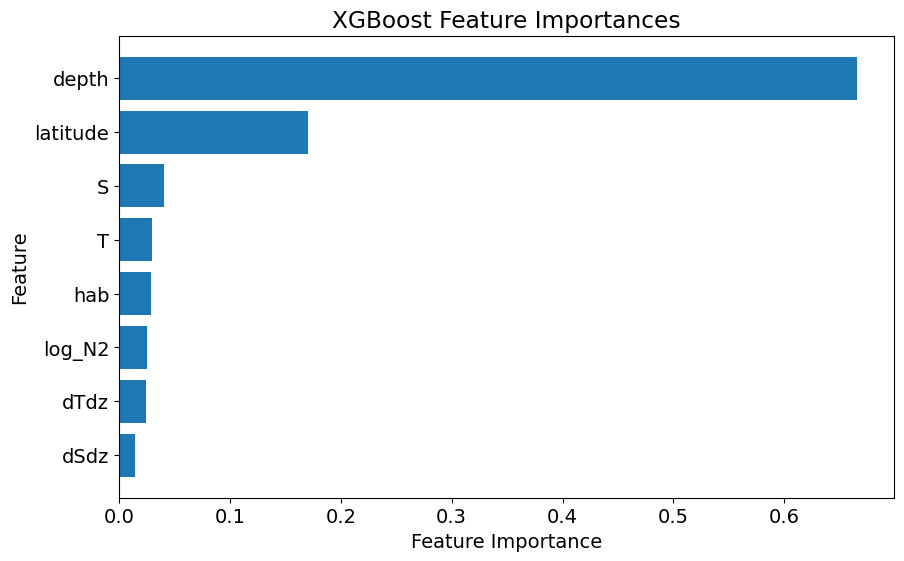

In [57]:
# Features:
xstringlist3 = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2']

# We want to predict:
ystringlist3 = ['log_eps']

xgb_regressor3, r2, y_test, y_pred, X_test, feature_importances = XGBoost_regressor(arctic_df, xstringlist3, ystringlist3)

In [58]:
southern_df = global_df[global_df['latitude'] < -60]

X_test_S = southern_df[xstringlist3]
y_test_S = southern_df[ystringlist3]
y_pred_S = xgb_regressor3.predict(X_test_S)
r2 = r2_score(y_test_S, y_pred_S)
print(r2)

-303.2643757220732


In [81]:
X_test_dfS

,S,T,latitude,hab,depth,dSdz,dTdz,log_N2,index
71480,34.729710,1.064112,-61.663963,133.0,-1898.0,0.000028,0.002070,-5.547626,71480
71481,34.731262,1.083000,-61.663963,143.0,-1898.0,0.000028,0.002070,-5.547626,71481
71482,34.730278,1.105514,-61.663963,153.0,-1898.0,-0.000134,0.001843,-5.430390,71482
71483,34.728573,1.119851,-61.663963,163.0,-1898.0,-0.000108,0.000964,-5.649480,71483
71484,34.728123,1.124801,-61.663963,173.0,-1898.0,-0.000094,0.000733,-5.789793,71484
...,...,...,...,...,...,...,...,...,...
185638,34.694181,0.187432,-63.996442,30.0,-4275.0,0.000003,0.000040,-4.770149,185638
185639,34.694258,0.187035,-63.996442,20.0,-4275.0,-0.000011,0.000043,-4.728661,185639
185640,34.694394,0.186564,-63.996442,10.0,-4275.0,-0.000009,0.000056,-4.807593,185640
185641,34.694430,0.185910,-63.996442,0.0,-4275.0,-0.000009,0.000075,-4.870389,185641


In [82]:
y_test_dfS

,log_eps,index
71480,-7.399584,71480
71481,-7.176321,71481
71482,-7.264928,71482
71483,-7.395813,71483
71484,-7.270470,71484
...,...,...
185638,-9.896106,185638
185639,-9.990089,185639
185640,-9.959646,185640
185641,-9.969459,185641


In [83]:
y_pred_dfS

,eps_pred
0,-20.814327
1,-20.088957
2,-19.860666
3,-21.700787
4,-22.081711
...,...
49167,-14.273310
49168,-20.285168
49169,-19.828463
49170,-19.553490


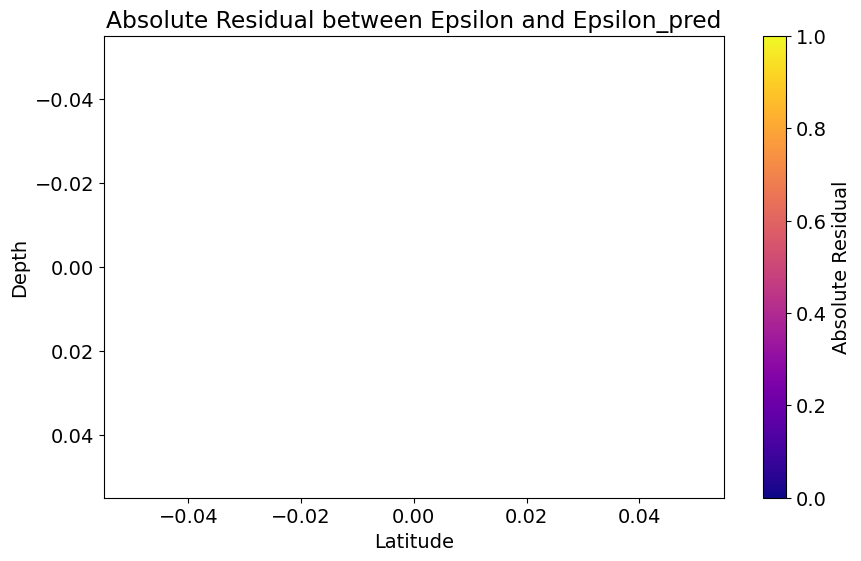

In [78]:
# Reshape y_pred
y_pred_S = np.reshape(y_pred_S, (-1, 1))
X_test_dfS = pd.DataFrame(X_test_S, columns=xstringlist3)
y_test_dfS = pd.DataFrame(y_test_S, columns=ystringlist3)
y_pred_dfS = pd.DataFrame(y_pred_S, columns=['eps_pred'])
S_testdf = create_testdf(X_test_dfS, y_test_dfS, y_pred_dfS)
plot_residuals(S_testdf)

## Hyperparameter tuning

In [84]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def XGBoost_regressor_tuning(dataframe, xfeatures, yfeatures):
    if "Tu_label" in xfeatures:
        hallo = Tu_label(dataframe.Tu)
        dataframe["Tu_label"] = hallo

        dataframe = encode_tulabel(dataframe)

    if 'log_eps' not in dataframe.columns:
        dataframe['log_eps'] = dataframe['eps'].apply(lambda x: math.log(x))

    # Stop depth at 300m
    dataframe = dataframe[dataframe["depth"] <= 300]

    x = dataframe[xfeatures].values
    y = dataframe[yfeatures].values

    # Split into train and test sets
    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

    # Define the parameter grid for grid search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001]
    }

    # Define the XGBoost regressor
    xgb_regressor = xgb.XGBRegressor(random_state=SEED)

    # Perform grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)

    # Plot feature importances
    feature_importances = best_model.feature_importances_
    sorted_indices = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
    plt.yticks(range(len(feature_importances)), [xfeatures[i] for i in sorted_indices])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('XGBoost Feature Importances')
    plt.show()

    return best_model, r2, y_test, y_pred, X_test, feature_importances, best_params


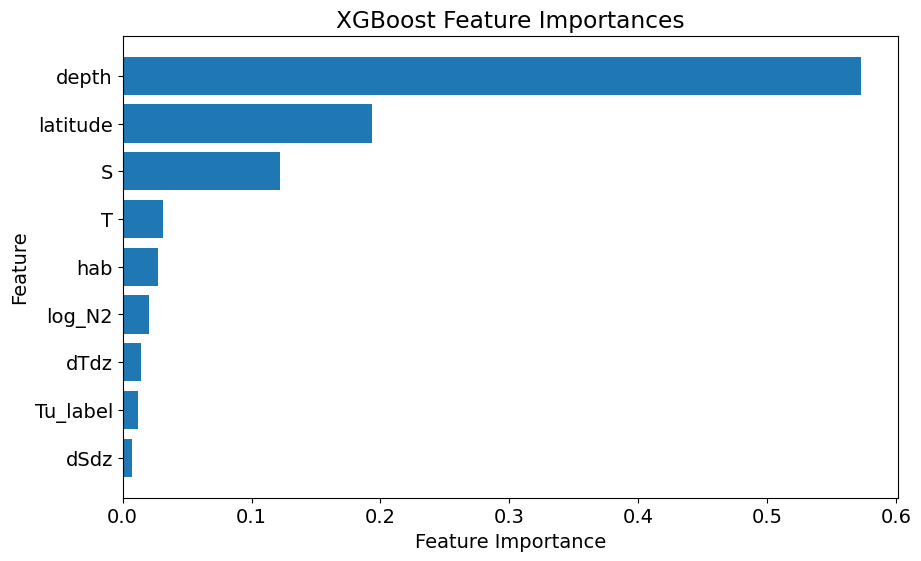

In [85]:
# Features:
xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']

# We want to predict:
ystringlist = ['log_eps']

best_model, r2_tune, y_test_tune, y_pred_tune, X_test_tune, feature_importances_tune, best_params = XGBoost_regressor_tuning(arctic_df, xstringlist , ystringlist)

In [14]:

best_model_params = best_model.get_params()
print(best_model_params)

NameError: name 'best_model' is not defined

## Do global model as well

In [ ]:
# Features:
xstringlist_g = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2']

# We want to predict:
ystringlist_g = ['log_eps']

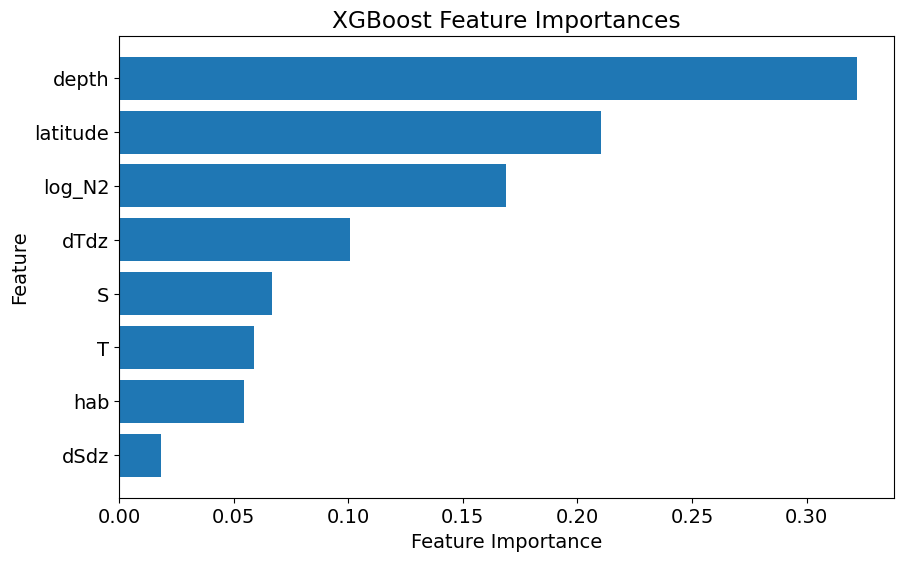

In [28]:
global_xgb_regressor, global_r2, global_y_test, global_y_pred, global_X_test, global_feature_importances = XGBoost_regressor(global_df, xstringlist , ystringlist)

In [29]:
print(global_r2)

0.6339672666621631


In [ ]:
best_model_g, r2_tune_g, y_test_tune_g, y_pred_tune_g, X_test_tune_g, feature_importances_tune_g = XGBoost_regressor_tuning(global_df, xstringlist_g, ystringlist_g)

In [ ]:
print(r2_tune_g)

In [ ]:
# Save the best_model
with open('models/best_model_global_xbg.pickle', 'wb') as file:
    pickle.dump(best_model_g, file)
    
best_model_params_g = best_model.get_params()
print(best_model_params_g)

### use this model to predict epsilon for arctic_df

In [30]:
# Make predictions on arctic_df using global_xgb_regressor
arctic_X_test = arctic_df[xstringlist].values
arctic_y_pred = global_xgb_regressor.predict(arctic_X_test)

# Evaluate the predictions on arctic_df using global_y_test
arctic_y_test = arctic_df[ystringlist].values
arctic_r2 = r2_score(arctic_y_test, arctic_y_pred)

# Get feature importances for arctic_df
arctic_feature_importances = global_xgb_regressor.feature_importances_

In [31]:
print("Using global XGboost model on arctic data", arctic_r2)

-25.789339171054312

# perform model on both arctic and on global

In [16]:
import math
arctic_df['log_eps'] = arctic_df['eps'].apply(lambda x: math.log(x))

In [15]:
global_df = global_df.rename(columns={'z': 'depth', 'lat': 'latitude', 'log_N2_sort': 'log_N2'})

In [19]:
concatenated_df = pd.concat([global_df, arctic_df], axis=0)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects